## EDA of num dataset (business calls and sms data)

Examine data from `num` dataset and decide what extra features can we get.


In [1]:
import pandas as pd
import numpy as np
from utils import eda
import plotly.express as px

In [2]:
RANDOM_SEED = 42
TARGET_KEY = "target"

In [3]:
df_train_targets = pd.read_parquet(
    "./data/train_fe/",
    columns=[TARGET_KEY],
)

In [4]:
target_counts = df_train_targets.groupby(TARGET_KEY)[TARGET_KEY].count()

target_labels = {
    1: "<20 years",
    2: "20-30 years",
    3: "30-40 years",
    4: "40-50 years",
    5: ">50 years",
}

df_target_dist = pd.DataFrame(
    {
        "label": target_counts.index.map(lambda x: target_labels[x]),
        "count": target_counts,
        "dataset%": target_counts.apply(
            lambda x: round(x / len(df_train_targets) * 100, 2)
        ),
    }
).reset_index()

print(df_target_dist)

fig = px.pie(
    df_target_dist,
    values="count",
    names="label",
    title=f"Total records: {len(df_train_targets)}",
)

fig.update_traces(textposition="inside", textinfo="percent+value+label")
fig.show()

   target        label  count  dataset%
0       1    <20 years  18960     12.90
1       2  20-30 years  27428     18.66
2       3  30-40 years  39579     26.93
3       4  40-50 years  31692     21.57
4       5    >50 years  29294     19.93


Dictionary:

- `abon_id` — subscriber id
- `bnum` — Business number name that was contacted with subscriber
- `call_cnt_out` — outgoing calls count
- `call_cnt_in` — incoming calls count
- `call_dur_out` — outgoing calls duration
- `call_dur_in` — incoming calls duration
- `cnt_sms_out` — outgoing sms count
- `cnt_sms_in` — incoming sms count


In [5]:
df_train_num = pd.read_parquet("./data/train_num")
df_train_num = df_train_num.merge(
    df_train_targets,
    how="left",
    left_index=True,
    right_index=True,
)

print(df_train_num.info())
df_train_num

<class 'pandas.core.frame.DataFrame'>
Index: 803268 entries, 1525928 to 132551440
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bnum          803268 non-null  string 
 1   call_cnt_out  803268 non-null  float16
 2   call_cnt_in   803268 non-null  float16
 3   call_dur_out  803268 non-null  float16
 4   call_dur_in   803268 non-null  float16
 5   cnt_sms_out   803268 non-null  float16
 6   cnt_sms_in    803268 non-null  float16
 7   target        803268 non-null  int8   
dtypes: float16(6), int8(1), string(1)
memory usage: 19.2 MB
None


,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,target
abon_id,,,,,,,,
1525928,380445990777,1.480469,0.000000,24.984375,0.000000,0.000000,0.000000,4
1525928,380672368404,3.589844,0.000000,27.671875,0.000000,0.000000,0.000000,4
1525928,380977770109,3.589844,2.207031,29.750000,28.640625,0.000000,0.000000,4
1525928,chokolovka,0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,4
1525928,dsns ukr,0.000000,0.000000,0.000000,0.000000,0.000000,3.589844,4
...,...,...,...,...,...,...,...,...
132550466,4567890,0.000000,0.000000,0.000000,0.000000,1.480469,0.000000,3
132550466,facebook,0.000000,0.000000,0.000000,0.000000,0.000000,2.921875,3
132550466,telegram,0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,3


In [6]:
eda.print_missing(df_train_num)

Missing values report:
No missing values found!


,Total,Rate


In [7]:
df_train_num["abon_id"] = df_train_num.index
eda.print_uniq(df_train_num)

Unique values report:
                uniq      rate
target             5  0.000006
cnt_sms_out       63  0.000078
call_cnt_in       93  0.000116
call_cnt_out      99  0.000123
cnt_sms_in       314  0.000391
call_dur_in     1191  0.001483
call_dur_out    1491  0.001856
bnum           31838  0.039636
abon_id       111835  0.139225
Total rows: 803268


<Axes: xlabel='bnum_id', ylabel='target'>

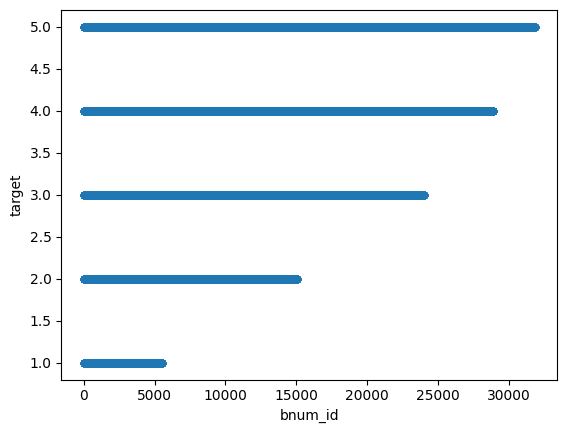

In [8]:
df_sorted = df_train_num.sort_values(by=["target"])
id_map = {}


def index_bnum(bnum):
    if not (bnum in id_map):
        id_map[bnum] = len(id_map) + 1

    return id_map[bnum]


df_sorted["bnum_id"] = df_sorted["bnum"].apply(index_bnum)

df_sorted.plot.scatter(x="bnum_id", y=TARGET_KEY)

Let's look the distribution of business numbers across subscribers and particular target groups. The hypothesis is that there should be some bnums that are more common for some group of subscribers while is not common for the other. Therefore we don't want to examine bnums that are used only by several subscribers and bnums that are used by majority of subscribers.

In [9]:
bins = [
    0,
    2,
    5,
    10,
    15,
    20,
    30,
    50,
    100,
    500,
    1000,
    2000,
    5000,
    10000,
    20000,
    30000,
    100000,
]

count, division = np.histogram(
    df_train_num.groupby("bnum")["abon_id"].count().reset_index(name="count")["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_bnum,bnum_count
0,2,16308
1,5,8854
2,10,2790
3,15,1040
4,20,552
5,30,542
6,50,564
7,100,453
8,500,541
9,1000,104


In [10]:
mean_target_counts_per_bnum = (
    df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["bnum", "count"]]
    .groupby("bnum")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_bnum["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_target_per_bnum,bnum_count
0,2,24044
1,5,5504
2,10,1035
3,15,352
4,20,148
5,30,205
6,50,171
7,100,185
8,500,152
9,1000,18


Two or five subscribers per group seems not that significant, even 10 and 15. This way we will drop the major part of data that will unlikely have any value for the model.

Additionally let's examine the tail of distribution:

In [11]:
with pd.option_context("display.max_rows", None):
    print(
        mean_target_counts_per_bnum[mean_target_counts_per_bnum["count"] >= 2000]
        .sort_values(by="count", ascending=False)
    )

             bnum    count
21822    dsns ukr  14523.2
30524     ukraine  13406.8
26684  novaposhta   4609.0
27733  privatbank   4412.8
27063  oschadbank   2765.0
21889    e-health   2612.0


Drop `dsns ukr` and `ukraine` because such calls/sms received without subscriber decision therefore it can not be useful for behavior (age) prediction.

In [12]:
rows_before = len(df_train_num)
print(f"Rows before: {rows_before}")
df_train_num = df_train_num[
    df_train_num["bnum"].isin(
        mean_target_counts_per_bnum[
            (mean_target_counts_per_bnum["count"] >= 15)
            & (mean_target_counts_per_bnum["count"] < 10000)
        ]["bnum"]
    )
]
print(
    f"Rows after: {len(df_train_num)}. Rows dropped: {rows_before - len(df_train_num)}"
)

Rows before: 803268
Rows after: 533148. Rows dropped: 270120


In [13]:
mean_target_counts_per_bnum = (
    df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["bnum", "count"]]
    .groupby("bnum")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_bnum["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_target_per_bnum,bnum_count
0,2,0
1,5,0
2,10,0
3,15,0
4,20,148
5,30,205
6,50,171
7,100,185
8,500,152
9,1000,18


In [33]:
def plot_filtered():
    abon_by_bnum = df_train_num.groupby("bnum")["abon_id"].count()

    df_sorted = (
        df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
        .count()
        .reset_index(name="count")
    )
    df_sorted["bnum_percent"] = df_sorted.apply(
        lambda series: series["count"] / abon_by_bnum[series["bnum"]],
        axis=1,
    )

    # df_sorted = df_sorted[df_sorted["count"] > 20]

    df_sorted = df_sorted.sort_values(by=["target", "count"])
    id_map = {}

    def index_bnum(bnum):
        if not (bnum in id_map):
            id_map[bnum] = len(id_map) + 1

        return id_map[bnum]

    df_sorted["bnum_id"] = df_sorted["bnum"].apply(index_bnum)
    df_sorted["bin"] = df_sorted["count"].apply(
        # find the bin value
        lambda count: str(next(x for x in bins if count < x))
    )

    # df_sorted.plot.scatter(x="bnum_id", y=TARGET_KEY)
    return px.scatter(
        df_sorted,
        x="bnum_id",
        y=TARGET_KEY,
        color="bin",
        hover_name="count",
        title=f"Aggregated bnum counts per target. Bnum count: {df_sorted['bnum'].nunique()}",
        size="bnum_percent",
        # size_max=50,
    )


plot_filtered()

In [7]:
df_abons_without_bnums = df_train_targets.index.difference(df_train_num.index)

print(
    f"Subscribers without bnum data: {len(df_abons_without_bnums)} ({len(df_abons_without_bnums)/len(df_train_targets)*100:.2f}%)"
)

Subscribers without bnum data: 35118 (23.90%)
